# Selection of reservoirs
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 26-07-2023<br>

**Introduction:**<br>
In this notebook I will load different reservoir datasets (GloFAS, [GLWD](https://www.sciencedirect.com/science/article/pii/S0022169404001404) and [GRanD](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1890/100125)), compare them, and select reservoirs from the GRanD dataset that aren't currently included in GloFAS. The objective is to include in GloFAS a representative proportion of the global storage capacity, that [Mulligan et al. (2020)](https://www.nature.com/articles/s41597-020-0362-5) estimate between 7,000 and 8,300 km³.

In [22]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import glob
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
from shapely.geometry import Point
from pathlib import Path

from utils import select_reservoirs

In [4]:
# global reservoir storage capacity, from Mulligan et al. (2020)
total_volume = np.mean([7000, 8300]) * 1000 # hm³

# paths
path_datasets = Path('Z:/nahaUsers/casadje/datasets/')
path_out = '../results/reservoirs/selection/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

## Global Flood Awareness System (GloFAS)
[Zajac et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0022169417301671) defines the criteria used to select reservoirs in GloFAS:

* Reservoirs in GLobal Lakes and Wetlands Database (GLWD) level 1 with a storage capacity equal or larger than 500 hm³.
* Reservoirs in the Global Reservoir and Dam Database (GRanD) with a storage capacity larger than 100 hm³.

In [44]:
# minimum storage capacity included in GloFAS
min_volume = 100 # hm³

# spatial resolution in GloFAS v4
glofas_pixel = .05 # degrees

# path where the GloFAS data is stored
path_GloFAS = Path('../data/reservoirs/GloFAS/')

I will load two products from GloFAS: a raster with the location and ID of the reservoirs, and a table with the metadata. The raster is only loaded to check that the coordinates in the metadata correspond to the corrected coordinates used in LISFLOOD. To the metadata I will add as new attributes the reservoir tables used in the LISFLOOD simulation, which contain the reservoir parameters: total storage, filling and outflow at different reservoir levels.

#### Raster

In [45]:
glofas_raster = xr.open_dataset(path_GloFAS / '20220802_reservoirs_Global_03min.nc')['res']

# remove rows/columns with all NaN
aux = glofas_raster.where(~glofas_raster.isnull(), drop=True)
# extract an array of reservoir ID
ids = np.unique(aux)
ids = ids[~np.isnan(ids)]

# extract coordinates of each reservoir
glofas_coords = pd.DataFrame(index=ids, columns=['lon', 'lat'])
for id in tqdm(glofas_coords.index):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    glofas_coords.loc[id] = cell.lon.data[0], cell.lat.data[0]
glofas_coords = glofas_coords.round(3)

del aux

  0%|          | 0/684 [00:00<?, ?it/s]

#### Metadata

In [54]:
# load GloFAS metadata
glofas = pd.read_csv(path_GloFAS / 'GLOFAS_HRES_reservoirs_metadata.csv')
glofas.set_index('ResID', inplace=True)

# create geopandas.GeoDataFrame
glofas = gpd.GeoDataFrame(glofas, geometry=[Point(xy) for xy in zip(glofas.LisfloodX3, glofas.LisfloodY3)])
glofas.crs = 'EPSG:4326'

# # simplify lake name
# glofas.LAKE_NAME = glofas.LAKE_NAME.str.lower()
# glofas.LAKE_NAME = glofas.LAKE_NAME.str.replace(r'(lake|reservoir)', '', case=False)
# glofas.LAKE_NAME = glofas.LAKE_NAME.str.strip()
# glofas.DAM_NAME = glofas.DAM_NAME.str.lower()
# glofas.RIVER = glofas.RIVER.str.lower()

# add attributes from the tables used in LISFLOOD
for file in glob.glob(f'{path_GloFAS}\\*.txt'):
    var = file.split('\\')[-1].split('_')[0][1:]
    try:
        df = pd.read_csv(file, sep='\t', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['ResID', var]
        df.set_index('ResID', inplace=True, drop=True)
        glofas[var] = df
    except:
        print(file)
        continue
glofas.stor /= 1e6 # convert storage from m3 to hm³

#### Comparison

In [56]:
print('no. reservoirs in the metadata:\t\t{0}'.format(glofas.shape[0]))
print('no. reservoirs in the raster:\t\t{0}'.format(glofas_coords.shape[0]))
print('reservoirs missing in the metadata:\t{0}'.format(glofas_coords.index.difference(glofas.index).to_list()))
print('reservoirs missing in the raster:\t{0}'.format(glofas.index.difference(glofas_coords.index).to_list()))

no. reservoirs in the metadata:		685
no. reservoirs in the raster:		684
reservoirs missing in the metadata:	[-9999.0]
reservoirs missing in the raster:	[361, 385]


* The Therthar lake (Irak) is repeated twice in the raster with ID -9999 and 643. I remove the value -9999.
* There are 2 reservoirs in the metadata that are not in the raster:
    * 361 is Lake Ozark, which is repeated with the ID 362. In the GRanD database there are two consecutive reservoirs in that river, but the reservoir upstream is not in GloFAS. It could be that the chain of reservoirs in GloFAS is the combination of both.
    * 385 is the Kentucky lake, which is repeated with the ID 386. They are actually two different reservoirs in two tributaries just before their confluence. They are both in the GRanD data base, so I have to check if the GloFAS total volume represents the sum of the volume of both reservoirs.
    
The coordinates of the reservoir in the raster are those in the fields _LisfloodX3_ and _LisfloodY3_ in the metadata.

In [57]:
# remove one of the instances of the Therthar lake
glofas_coords.drop(-9999, axis=0, inplace=True)

no. reservoirs in GloFAS:		685
total reservoir volume in GloFAS:	4588500 hm³ (60.0%)
no. reservoirs (V > 100 hm³):		683


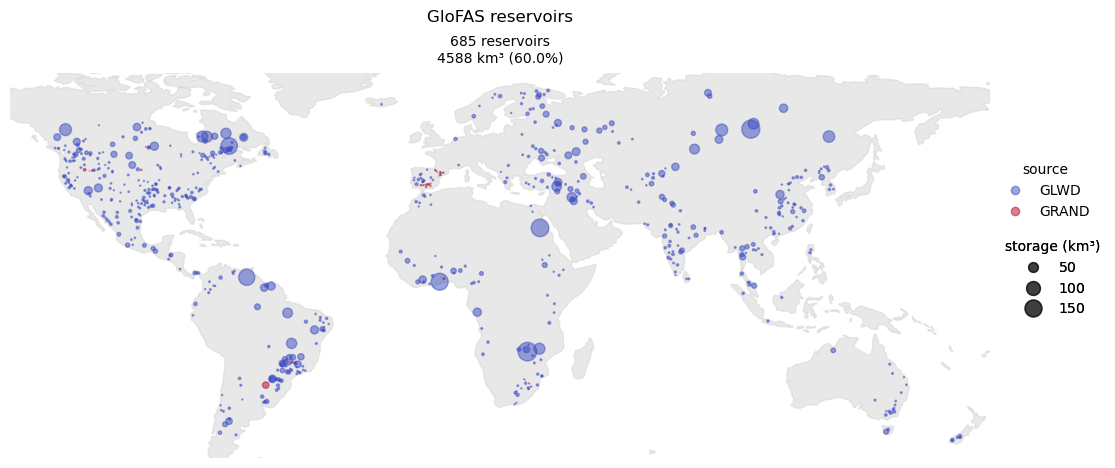

In [58]:
# map of GloFAS reservoirs
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
c = glofas.Source.map({'GLWD': 0, 'GranD': 1}).values
scatter = ax.scatter(glofas.geometry.x, glofas.geometry.y, s=glofas.stor / 1000, cmap='coolwarm', c=c, alpha=.5)
ax.text(.5, 1.125, 'GloFAS reservoirs', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
text = '{0} reservoirs\n{1:.0f} km³ ({2:.1f}%)'.format(glofas.shape[0], glofas.stor.sum() / 1000, glofas.stor.sum() / total_volume * 100)
ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
ax.axis('off');

# legend
handles1, labels1 = scatter.legend_elements(prop='colors', alpha=0.5)
labels1 = ['GLWD', 'GRAND']
legend1 = ax.legend(handles1, labels1, title='source', bbox_to_anchor=[1.025, .55, .09, .25], frameon=False)
ax.add_artist(legend1)
legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num=4, alpha=.5), title='storage (km³)', bbox_to_anchor=[1.025, .35, .1, .25], frameon=False)
ax.add_artist(legend2);

# save
plt.savefig(f'{path_out}glofas_reservoirs.jpg', dpi=300, bbox_inches='tight')

print('no. reservoirs in GloFAS:\t\t{0}'.format(glofas.shape[0]))
print('total reservoir volume in GloFAS:\t{0:.0f} hm³ ({1:.1f}%)'.format(glofas.stor.sum(), glofas.stor.sum() / total_volume * 100))
print('no. reservoirs (V > 100 hm³):\t\t{0}'.format((glofas.stor >= min_volume).sum()))

***Figure 1**. Reservoirs included in GloFAS. The size of the dots represents the storage capacity. Blue dots are reservoirs whose source is GLWD, whereas the source of red dots is GRanD.*

GloFAS includes **685 reservoirs with a total storage capacity of 4,600 km³ (60% of the global storage capacity)**. 2 of those reservoirs (GloFAS ID 665 and 680) do not comply with the minimum reservoir volume mentioned in Zanja el al. (2017). The data source of 650 reservoirs is the GLWD data set, and only 35 come from the GRanD dataset.

## Global Lakes and Wetlands Database (GLWD)

GLWD is the primary source of information in the reservoirs currently included in GloFAS. The GLWD level 1 product includes polygons of the water bodies (either lakes or reservoirs), from which I will keep only reservoirs. 

In [59]:
# import data set
path_glwd = path_datasets / 'lakes/GLWD/level1/'
glwd = gpd.read_file(path_glwd / 'glwd_1.shp')
glwd.set_index('GLWD_ID', drop=True, inplace=True)
glwd.crs = 'EPSG:4326'

# keep only reservoirs
glwd = glwd.loc[glwd.TYPE == 'Reservoir']

# convert reservoir volume to hm³ (million cubic meters)
glwd['VOLUME_MCM'] = glwd.VOLUME_CKM * 1000
glwd.drop('VOLUME_CKM', axis=1, inplace=True)

# remove empty fields
glwd.dropna(axis=1, how='all', inplace=True)

# convert polygon GeoDataFrame to point GeoDataFrame
glwd = gpd.GeoDataFrame(glwd, geometry=[Point(xy) for xy in zip(glwd.LONG_DEG, glwd.LAT_DEG)])
glwd .crs = 'EPSG:4326'

# # tune lake names in GLWD
# glwd.LAKE_NAME = glwd.LAKE_NAME.str.lower()
# glwd.LAKE_NAME = glwd.LAKE_NAME.str.replace(r'(lake|reservoir)', '', case=False)
# glwd.LAKE_NAME = glwd.LAKE_NAME.str.strip()

no. reservoirs in GLWD:		654
total reservoir volume in GLWD:	4615220 hm³ (60.3%)
no. reservoirs (V > 500 hm³):	654


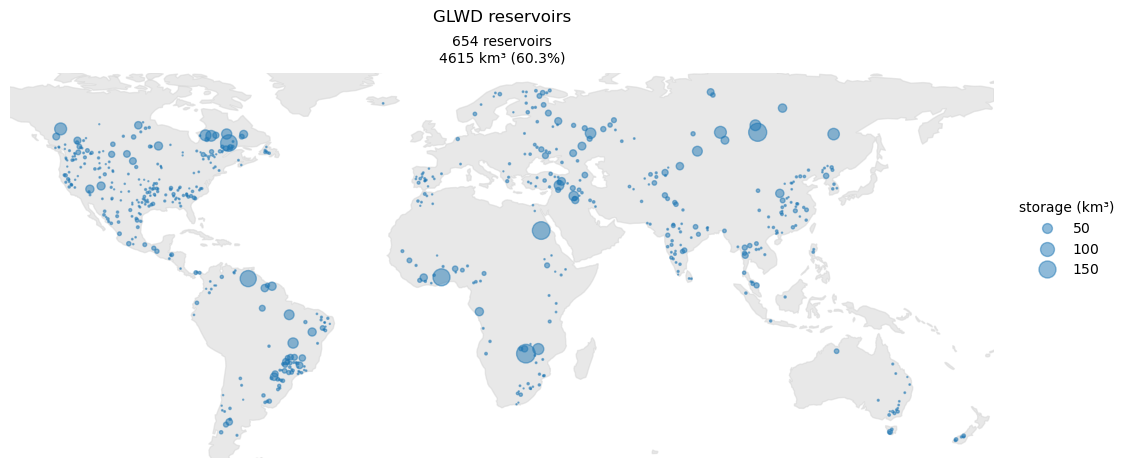

In [60]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
ax.scatter(glwd.geometry.x, glwd.geometry.y, s=glwd.VOLUME_MCM / 1000, alpha=.5)
ax.text(.5, 1.125, 'GLWD reservoirs', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
text = '{0} reservoirs\n{1:.0f} km³ ({2:.1f}%)'.format(glwd.shape[0], glwd.VOLUME_MCM.sum() / 1000, glwd.VOLUME_MCM.sum() / total_volume * 100)
ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
ax.axis('off')

# legend
handles, labels = scatter.legend_elements(prop='sizes', num=4, alpha=0.5, c='C0')
fig.legend(handles, labels, bbox_to_anchor=[.725, .45, .1, .2], title='storage (km³)', frameon=False);

# save
plt.savefig(f'{path_out}glwd_reservoirs.jpg', dpi=300, bbox_inches='tight')

print('no. reservoirs in GLWD:\t\t{0}'.format(glwd.shape[0]))
print('total reservoir volume in GLWD:\t{0:.0f} hm³ ({1:.1f}%)'.format(glwd.VOLUME_MCM.sum(), glwd.VOLUME_MCM.sum() / total_volume * 100))
print('no. reservoirs (V > 500 hm³):\t{0}'.format((glwd.VOLUME_MCM >= 500).sum()))

***Figure 2**. Reservoirs in the GLWD data set. The dot size indicates the storage capacity.*

The GLWD data set includes 654 reservoirs, all with a storage capacity larger than 500 hm³. Even if the number of reservoirs in GLWD is smaller than in GloFAS, the total storage capacity of the data set is slightly higher than that of GloFAS. This indicates that some reservoirs in GLWD are not included in GloFAS

In [61]:
# reservoirs in GLWD not included in GloFAS
missing = list(set(glwd.index) - set(glofas.GLWD_ID))
print('{0} reservoirs in GLWD are missing in GloFAS:\t{1}.\nThey account for {2:.0f} hm³ storage capacity.'.format(len(missing), missing, glwd.loc[missing, 'VOLUME_MCM'].sum()))

7 reservoirs in GLWD are missing in GloFAS:	[33, 641, 780, 942, 847, 496, 3359].
They account for 72430 hm³ storage capacity.


647 reservoirs (all but 7) in GLWD are included in GloFAS. However, the field _Source_ in the GloFAS metadata erroneously indicates that 650 reservoirs are from GLWD.

## Global Reservoir and Dam (GRanD)

GloFAS includes 35 reservoirs from the GRanD data set. Figure 1 shows that these reservoirs are located in Spain (23), USA (4), South Africa (4), Canada (2), Togo (1), Brazil (1) and Paraguay (1). I will analyse here the complete GRanD data set to identify possible reservoirs to be added in GloFAS.

GRanD includes both a point shapefile of dams and a polygon shapefile with reservoirs. The amount of reservoirs is slightly smaller than that of dams, but the attributes are the same, so I will use only the dams for the analysis.

```Python
# import reservoir polygons
grand_reservoirs = gpd.read_file(f'{path_GRanD}GRanD_reservoirs_v1_3.shp')
grand_reservoirs.set_index('GRAND_ID', drop=True, inplace=True)
```

In [62]:
# import data set
path_GRanD = path_datasets / 'reservoirs/GRanD/v1_3/'
grand = gpd.read_file(path_GRanD / 'grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)

# # tune lake names in GRanD
# grand.RES_NAME = grand.RES_NAME.str.lower()
# grand.RES_NAME = grand.RES_NAME.str.replace(r'(lake|reservoir)', '', case=False)
# grand.RES_NAME = grand.RES_NAME.str.strip()
# grand.DAM_NAME = grand.DAM_NAME.str.lower()
# grand.RIVER = grand.RIVER.str.lower()

# convert in NaN suspicios values of degree of regulation
grand.DOR_PC = grand.DOR_PC.replace(10000, np.nan)

GRanD:			7320 reservoirs		6881025 hm³ (89.9%)
GRanD (V >= 100 hm³):	3328 reservoirs		6750745 hm³ (88.2%)


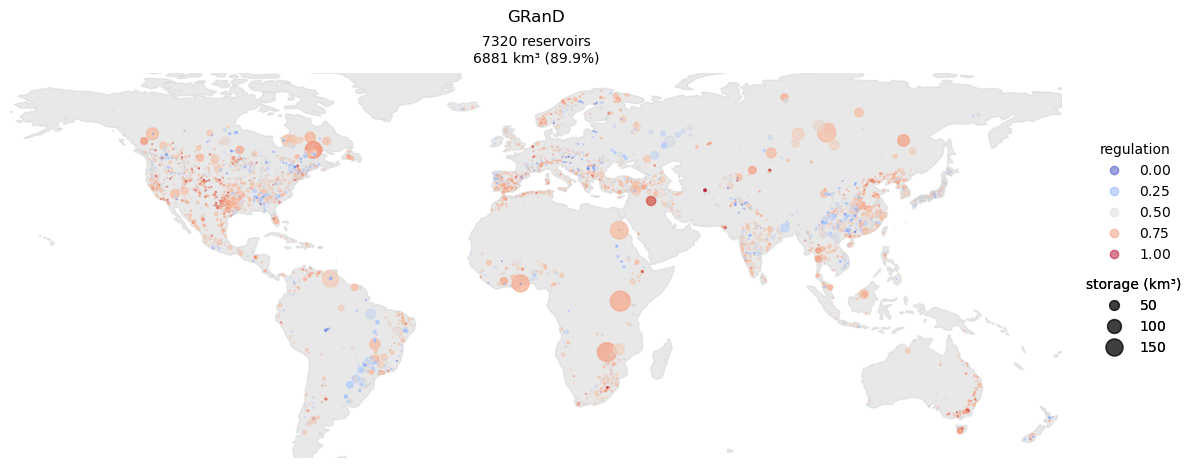

In [63]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
ax.scatter(grand.geometry.x, grand.geometry.y, s=grand.CAP_MCM / 1000, cmap='coolwarm', c=np.log10(grand.DOR_PC.replace(0, .1)), alpha=.7)
ax.text(.5, 1.125, 'GRanD', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
text = '{0} reservoirs\n{1:.0f} km³ ({2:.1f}%)'.format(grand.shape[0], grand.CAP_MCM.sum() / 1000, grand.CAP_MCM.sum() / total_volume * 100)
ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
ax.axis('off');

# legend
legend1 = ax.legend(*scatter.legend_elements(prop='colors', num=4, alpha=.5), title='regulation', bbox_to_anchor=[1.025, .6, .09, .25], frameon=False)
ax.add_artist(legend1)
legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num=4, alpha=.5), title='storage (km³)', bbox_to_anchor=[1.025, .25, .1, .25], frameon=False)
ax.add_artist(legend2)

# save
plt.savefig(f'{path_out}grand_reservoirs.jpg', dpi=300, bbox_inches='tight')

grand_volume = grand.CAP_MCM.sum()
print('GRanD:\t\t\t{0} reservoirs\t\t{1:.0f} hm³ ({2:.1f}%)'.format(grand.shape[0], grand_volume, grand_volume / total_volume * 100))
grand_mask_volume = grand.CAP_MCM >= min_volume
grand_volume_sel = grand.loc[grand_mask_volume, 'CAP_MCM'].sum()
print('GRanD (V >= {0} hm³):\t{1} reservoirs\t\t{2:.0f} hm³ ({3:.1f}%)'.format(min_volume, grand_mask_volume.sum(), grand_volume_sel, grand_volume_sel / total_volume * 100))

***Figure 3**. Dams included in the GRanD data set. The size of the dots represents the storage capacity of the reservoir and the colour the degree of regulation (red for stronger regulation).*

The GRanD data set includes more than 10 times more dams/reservoirs than either GloFAS or GLWD. However, less than a half (3328) of those reservoirs have a capacity of at least 100 hm³. These subset of reservoirs account for 88.2% of the global storage capacity (28.2% more than GloFAS).

Many of the reservoirs in GRanD are already included in GloFAS, but it is not clear since those reservoirs whose source was GLWD (the vast majority) do not include the _GRAND_ID_ field. In the following snippet I will fill in the GloFas metadata (*GRAND_ID*, *LAKE_NAME*, *RES_NAME*, *RIVER*) from the GRanD data set. The identification of matching dams will be simply base on proximity, defining a maximum number of pixels distance between the point in GloFAS and GRanD. After the automatic assignment, I've checked individually the remaining reservoirs in GloFAS without *GRAND_ID* and found some matches that I impose here.

In [64]:
# fill in empty values in the GloFAS metadata using the GRanD data set
for id in tqdm(glofas.index):
    if np.isnan(glofas.loc[id, 'GRAND_ID']):
        # extract info from GloFAS
        gf_lon, gf_lat = glofas.loc[id, ['LisfloodX3', 'LisfloodY3']]
        
        # compute "distance" from all points in GRanD
        diff = ((grand.LONG_DD - gf_lon)**2 + (grand.LAT_DD - gf_lat)**2)**.5
        if diff.min() <= 5 * glofas_pixel:
            grand_id = diff.idxmin()
            # grand_lake, grand_river = grand.loc[grand_id, ['RES_NAME', 'RIVER']]
            # if (gf_river == grand_river) | (gf_lake == grand_lake):
            #     glofas_.loc[id, ['GRAND_ID', 'LAKE_NAME', 'RIVER']] = grand_id, grand_lake, grand_river
            glofas.loc[id, 'GRAND_ID'] = grand_id
            attributes = {'LAKE_NAME': 'RES_NAME', 'DAM_NAME': 'DAM_NAME', 'RIVER': 'RIVER'}
            for gf_attr, grand_attr in attributes.items():
                if not isinstance(glofas.loc[id, gf_attr], str):
                    glofas.loc[id, gf_attr] = grand.loc[grand_id, grand_attr]

# conversion from GloFAS to GRanD found "manually"
map_glofas_grand = {9: 5043,
                    128: 279,
                    304: 707,
                    347: 6863,
                    # 384: ,
                    496: 6819,
                    561: 4431,
                    573: 4353,
                    603: 4356,
                    629: 702,
                    643: 4472}
for glofas_id, grand_id in map_glofas_grand.items():
    glofas.loc[glofas_id, 'GRAND_ID'] = grand_id
    attributes = {'LAKE_NAME': 'RES_NAME', 'DAM_NAME': 'DAM_NAME', 'RIVER': 'RIVER'}
    for gf_attr, grand_attr in attributes.items():
        if not isinstance(glofas.loc[id, gf_attr], str):
            glofas.loc[glofas_id, gf_attr] = grand.loc[grand_id, grand_attr]
            
print('GloFAS without GRAND_ID:\t{0} reservoirs\t\t{1:.0f} hm³ ({2:.1f}% GloFAS)'.format(glofas.GRAND_ID.isnull().sum(),
                                                                                       glofas.loc[glofas.GRAND_ID.isnull(), 'stor'].sum(),
                                                                                       glofas.loc[glofas.GRAND_ID.isnull(), 'stor'].sum() / glofas.stor.sum() * 100))

  0%|          | 0/685 [00:00<?, ?it/s]

GloFAS without GRAND_ID:	27 reservoirs		127460 hm³ (2.8% GloFAS)


In [71]:
# convert ID columns to integers
glofas.GRAND_ID = glofas.GRAND_ID.astype(pd.Int64Dtype())
glofas.GLWD_ID = glofas.GLWD_ID.astype(pd.Int64Dtype())

# export as shapefile
glofas.to_file(path_GloFAS / 'GloFAS_reservoirs.shp')

After the completion of the field `GRAND_ID`, only 27 reservoirs in GloFAS do not match with a reservoir in GRanD. I have inspected individually these 27 cases to check that they do not correpond to any reservoir in GRanD.

Now I will do the opposite analysis, I will list how many reservoirs in GRanD are not in GloFAS, keeping only those with a storage capacity over 100 hm³. Firt of all, I have discovered that some water bodies that GRanD considers as reservoirs are modelled in GloFAS as lakes (Lake Nipigon, Lake Winnipeg, Lake Reindeer...), so I will remove them from the list of "new" reservoirs.

In [20]:
# select GRanD reservoirs not included in GloFAS
missing = grand[grand_mask_volume].index.difference(glofas.GRAND_ID)
grand_new = grand.loc[missing]

# GRAND_ID of reservoirs considered in GloFAS as lakes
grand_id = [5058, 5295, 5087, 6528, 5779, 5132, 6453, 709, 1485, 1402, 731, 1493, 170, 1413, 110, 2051,
            758, 1964, 1528, 1944, 1390, 315, 883, 384, 2044, 1493, 3187, 4354, 3071, 4480, 4047, 4045,
             3395, 3714, 6796, 3701, 3726, 3174, 2623, 6606, 3150, 4492]
# remove those reservoirs from the list of new GRanD
grand_new.drop(grand_new.index.intersection(grand_id), axis=0, inplace=True)

# reservoir volume in GloFAS (including lakes that GRanD considers as reservoirs)
glofas_volume = glofas.stor.sum() + grand.loc[grand_id, 'CAP_MCM'].sum()

print('GRanD not in GloFAS (V >= {0} hm³):\t{1} reservoirs\t\t{2:.0f} hm³ ({3:.1f}%)'.format(min_volume,
                                                                                                    grand_new.shape[0],
                                                                                                    grand_new.CAP_MCM.sum(),
                                                                                                    grand_new.CAP_MCM.sum() / total_volume * 100))

GRanD not in GloFAS (V >= 100 hm³):	2646 reservoirs		2006852 hm³ (26.2%)


There are 2646 reservoirs in GRanD with a capacity larger than 100 hm³ that are not included in GloFAS. They account for a total storage capacity of 2,000 km³, 26% of the global reservoir capacity. 

Since the number of new reservoirs is too large, we need to establish other filters to limit the amount of reservoirs to be included in GloFAS. GRanD includes many attributes that can be useful as filters:

* The field `TIMELINE` includes the state of the reservoir: modified, under construction, replaced, destroyed, planned... I will remove all reservoirs with values 'Replaced', 'Planned', 'Destroyed', 'Under construction'.
* The `QUALITY` field defines how trustworthy is the information. Given the large amount of reservoirs, we could skip those with poor and unreliable quality.
* GRanD includes an estimate of average discharge in the field `DIS_AVG_LS` derived from HydroSHEDS and WaterGAP. It also includes the degree of regulation (field `DOR_PC`), as the ratio between storage capacity (`CAP_MCM`) and the total annual flow (`DIS_AVG_LS`). The degree of regulation could be an interesting characteristic in which to base the final selection of reservoirs.
* `CATCH_SKM` is the catchment area derived from HydroSHEDS and `CATCH_REP` the reported value. We could search for reservoirs with a minimum value of catchment area.

#### Remove reservoirs
**Data quality**

In [16]:
# keep only reservoirs with a fair or higher data quality
grand_mask_quality = grand_new.QUALITY.isin(['3: Fair', '2: Good', '1: Verified'])
grand_new = grand_new[grand_mask_quality]

print('GRanD not in GloFAS (V >= {0} hm³):\t{1} reservoirs\t\t{2:.0f} hm³ ({3:.1f}%)'.format(min_volume,
                                                                                                    grand_new.shape[0],
                                                                                                    grand_new.CAP_MCM.sum(),
                                                                                                    grand_new.CAP_MCM.sum() / total_volume * 100))

grand_new.QUALITY.value_counts()

GRanD not in GloFAS (V >= 100 hm³):	2433 reservoirs		1874511 hm³ (24.5%)


3: Fair        1256
2: Good        1168
1: Verified       9
Name: QUALITY, dtype: int64

**Timeline**

In [17]:
# remove non-existing reservoirs
grand_mask_timeline = grand_new.TIMELINE.isin(['Replaced', 'Planned', 'Destroyed', 'Under construction'])
grand_new = grand_new[~grand_mask_timeline]

print('GRanD not in GloFAS (V >= {0} hm³):\t{1} reservoirs\t\t{2:.0f} hm³ ({3:.1f}%)'.format(min_volume,
                                                                                                    grand_new.shape[0],
                                                                                                    grand_new.CAP_MCM.sum(),
                                                                                                    grand_new.CAP_MCM.sum() / total_volume * 100))

grand_new.TIMELINE.value_counts()

GRanD not in GloFAS (V >= 100 hm³):	2426 reservoirs		1873072 hm³ (24.5%)


Modified    15
Name: TIMELINE, dtype: int64

#### Select reservoirs to be added

After removing reservoirs with poor quality and that were replaced/distroyed, there remain more than 2400 instances with a volume of 1,800 km³ (24.5% of the global capacity). Adding all these reservoirs in GloFAS would suppose that 89.5% of the global reservoir capacity would be represented in it. To limit the amount of reservoirs to add in GloFAS, I will do a selection of reservoirs based on different variables (storage, catchment area, degree of regulation). The selection would keep only reservoirs up to a certain percentage of the global reservoir capacity.

In [18]:
# proportion of the global reservoir capacity to be included in GloFAS
proportion = .8

# storage capacity to be added in GloFAS to reach the target
target_volume = proportion * total_volume - glofas_volume

print(f'We need to add {target_volume} hm³ storage capacity to reach {proportion * 100}% of the global storage capacity.')

We need to add 1139450.5 hm³ storage capacity to reach 80.0% of the global storage capacity.


**Storage capacity**

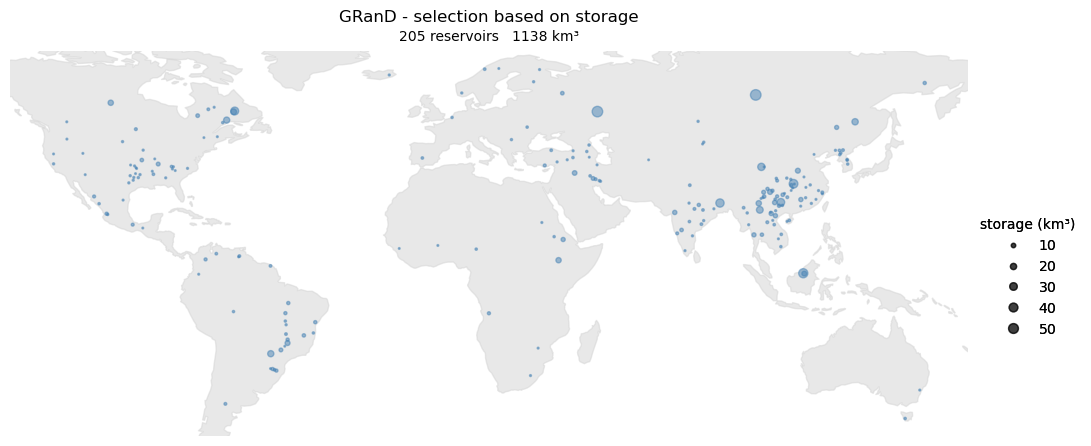

In [20]:
grand_new_v = select_reservoirs(grand_new, 'CAP_MCM', 'CAP_MCM', target_volume, c='steelblue',
                                title='GRanD - selection based on storage')

plt.savefig(f'{path_out}GRand_selection_storage.jpg', dpi=300, bbox_inches='tight')
grand_new_v.to_csv(f'{path_out}GRanD_selection_storage.csv')

***Figure 4**. Selection of GRanD reservoirs to be added in GloFAS based on storage capacity. The size of the dots represents the storage.*

**Catchment area**

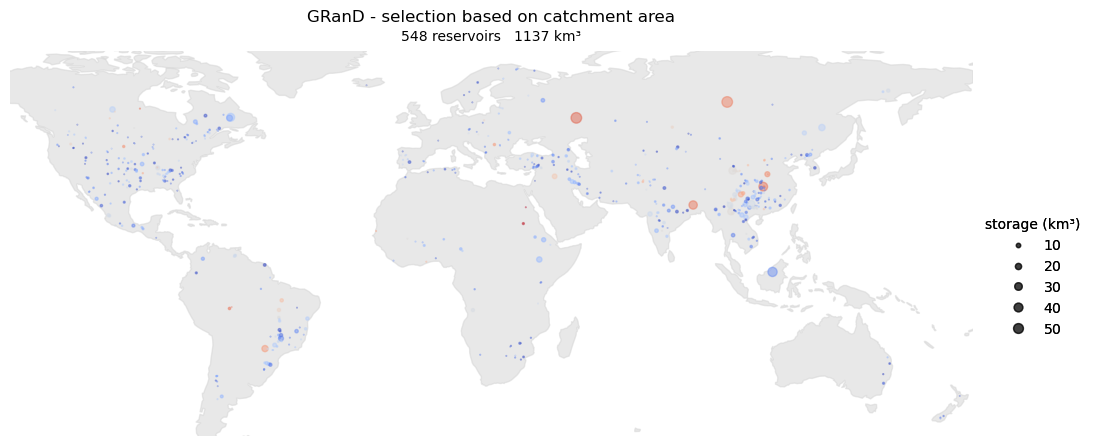

In [21]:
grand_new_a = select_reservoirs(grand_new, sort='CATCH_SKM', storage='CAP_MCM', target=proportion * total_volume - glofas_volume, #cmap='coolwarm_r',
                                c=np.log10(grand_new.CATCH_SKM.replace(0, 1)), title='GRanD - selection based on catchment area', legend_title='area (km²)')

plt.savefig(f'{path_out}GRand_selection_catchment_area.jpg', dpi=300, bbox_inches='tight')
grand_new_a.to_csv(f'{path_out}GRanD_selection_catchment_area.csv')

***Figure 5**. Selection of GRanD reservoirs to be added in GloFAS based on catchment area. The size of the dots represents the storage and the colour the catchment area (red for smaller catchments).*

**Degree of regulation**

A degree of regulation of 100% means that the storage capacity of the reservoir equals the annual flow of the river at the dam.

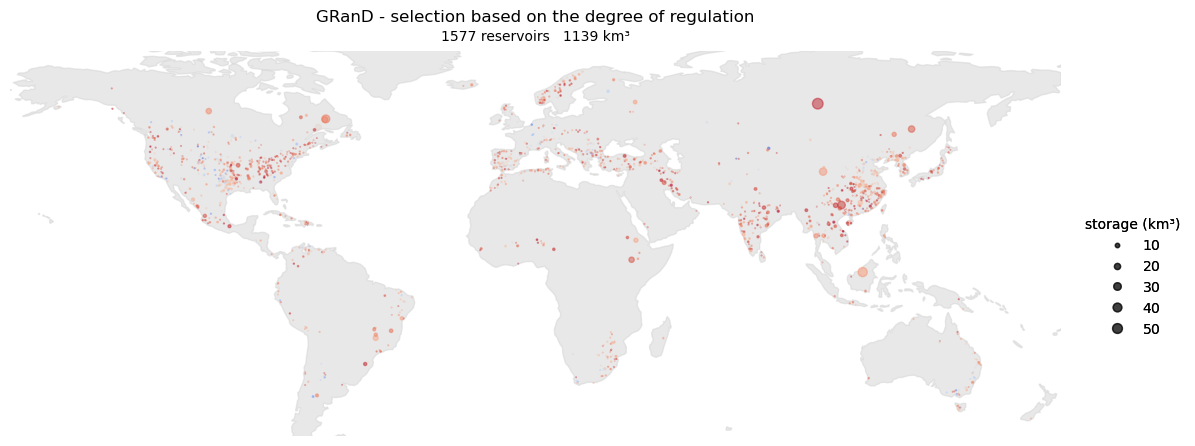

In [22]:
grand_new_dor = select_reservoirs(grand_new, sort='DOR_PC', storage='CAP_MCM', target=proportion * total_volume - glofas_volume, cmap='coolwarm_r',
                                  c=np.log10(grand_new.DOR_PC.replace([0, np.nan], 0.1)), title='GRanD - selection based on the degree of regulation')

plt.savefig(f'{path_out}GRand_selection_catchment_regulation.jpg', dpi=300, bbox_inches='tight')
grand_new_dor.to_csv(f'{path_out}GRanD_selection_regulation.csv')

***Figure 6**. Selection of GRanD reservoirs to be added in GloFAS based on the degree of regulation. The size of the dots represents the storage and the colour the degree of regulation (red for stronger regulation).*

As it could be expected, the **selection of reservoirs based on the storage capacity** is the option that requires fewer points to be added. Since we prioritize large reservoirs, we reach the target volume with fewer points. The geographical distributions is relatively even compared with the other two approaches. The amount of reservoirs to be added in Europe and North America is notably smaller. The biggest accumulation of new reservoirs is located in Southeast Asia.